Linear regression models of various kinds have often been applied to non-experimental data to model causal relations.

The simplest applications have a single, continuous outcome variable, and a single treatment or exposure variable, and often one or more covariates to mitigate bias.  Estimation is by way of OLS.  We consider covariate adjustments to reduce bias.

### But First, Looking Back...

Reflect back a minute on the previous regression example that was about inpatient satisfaction.  We assumed that the rating scale data are equal interval, continuous measures.  Certainly the _numerical_ difference, say, between ratings responses of 4 and 5 is the same as that for 7 and 8.

But what if such differences between between two numeric responses on these scales didn't always represent equal _psychological_ intervals, equal differences in perception or affect? What if the numbers are just labels for categories that are ordered, like ranks of experiences?

A measurement taxonomy widely adopted in social science measurement is the [_Levels of Measurement_](https://en.wikipedia.org/wiki/Level_of_measurement) classification described by S.S. Stevens.  Stevens defined four types of measurement scales in terms of their properties and the kinds of mathematical operations that are appropriate for use on data on them.  The four types are:  

* nominal - unordered categories, measures are classifications or memberships
* ordinal - ordered categories e.g. comparisons of rankings
* interval - metric differences, math operations not requiring an absolute origin, e.g. addition, subtraction
* ratio - magnitudes and metric quantities, operations accommodating absolute measurement scale origins  

What can be assumed about the level of measurement of psychological scales has implications for how it's best to model it or to statistically describe it.  It may make sense to average household incomes, but it doesn't make sense to do so with the names of members of a household.  

**QUESTION**  
What if the patient satisfaction data were ordinal measures?  How might that change how you would approach regressing stated satisfaction on the other variables?

### Facial Burn Data

Here and subsequently we're going to make use a small (n=77) data set about facial burns and their psychological ramifications that's from Dutch burn researchers.

The data are in the file `FacialBurns.csv`.  The variables in it are as follows:  

* Selfesteem = Rosenberg's self-esteem scale. 0 to 30, >=15 is positive view.  Measured 3 mo. post injury
* HADS = Combined anxiety and depression subscale scores, Hospital Anxiety and Depression Scale.  0 - 42, higher scores indicate greater anxiety+depression. Measured 3 mo. post injury
* Age = age in years at time of injury
* TBSA = Total burned surface area (%).  Measured at time of injury
* Sex = 1 = male, 2 = female 

### Packages

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np

In [2]:
# This bit widens all cells in this Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# This can just be commented out.  It's a kluge for one of my environ
# import os
# os.environ['R_HOME']='/home/lynd/anaconda36/lib/R'

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.interactive as r
import rpy2.interactive.packages
base=importr('base')
utils=importr('utils')
stats=importr('stats')

### Modeling

**MODEL 1**

The authors of the research have hypothesized that self esteem "causes" anxiety+depression as measured by HADS.  anxiety+depression "listens" to self esteem, to use a Pearl turn of phrase.  

**EXERCISE**  

Using dagitty.net, draw a graphical model in which self esteem "causes" HADS.  be sure to include any unobserved (or inferred) variables.

Estimate a bivariate regression model based on the graph you drew.

What validity checks for your model should you do?  

TIP: Refer to the R in Python Intro notebook.  Use the R package `lm` to estimate your model.

Your model may look something like this:  

\begin{align}
\hat{Y_i}=X_i\hat{\beta}+\epsilon_i
\end{align}

where $X_i$ is a vector with a 1 as an intercept term, and case i's value on the self esteem variable. $\hat{\beta}$ is a vector of regression coefficient estimates.  $\epsilon_i$ is an error term, a value on an exogenous variable to be estimated, given the model specification.  

**QUESTION**  
What assumptions do you think are appropriate to assess when evaluating the results of fitting this model to the data?

In [6]:
# Get the data

FacialBurns=pd.read_csv('data/FacialBurns.csv')

In [7]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()  # this is necessary

In [8]:
# convert this pandas DataFrame to an R data.frame
rFaceBurns=pandas2ri.py2ri(FacialBurns)

In [9]:
# Define a model formula
mod1Formula='HADS~Selfesteem'

In [10]:
# model estimation
mod1_Fit=stats.lm(mod1Formula,data=rFaceBurns)

In [11]:
mod1Summary=base.summary(mod1_Fit)
print(mod1Summary.names)  # here is what's in the result

 [1] "call"          "terms"         "residuals"     "coefficients" 
 [5] "aliased"       "sigma"         "df"            "r.squared"    
 [9] "adj.r.squared" "fstatistic"    "cov.unscaled" 



In [28]:
# Of interest here will be the coefficient for Self Esteem
print(mod1Summary.rx2('coefficients'))

              Estimate Std. Error  t value     Pr(>|t|)
(Intercept) 33.6540604  3.7592348  8.95237 1.834003e-13
Selfesteem  -0.7707697  0.1147096 -6.71931 3.103480e-09



In [27]:
# What Dx's do you think you should do, here? Looking at some graphs can be a good start.
# matplotlib notebook or matplotlib inline, here?
import matplotlib.pyplot as plt
rPlot=robjects.r['plot']  # get the plot() method
rGraphsOff=robjects.r["graphics.off"]

In [28]:
rPlot(mod1_Fit) # default regression Dx plots
plt.show()
#rGraphsOff()

rpy2.rinterface.NULL

In [16]:
# How are the residuals related to Self Esteem? Let's use seaborn, just for fun.
import seaborn as sns

In [17]:
# What type is this?
type(mod1Summary.rx2('residuals'))

rpy2.robjects.vectors.FloatVector

In [45]:
type(rFaceBurns.rx2('Selfesteem'))

rpy2.robjects.vectors.IntVector

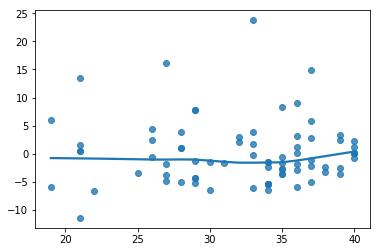

In [29]:
# seaborn needs np arrays as input
lowPlot1=sns.regplot(np.array(rFaceBurns.rx2('Selfesteem')),np.array(mod1Summary.rx2('residuals')),lowess=True)
plt.show()

### Causal Interpretation

To interpret this model in a causal manner, we assume that the expected value of $Y_i$ can be estimated given $X_i$.  That is, $\mathbf{E}[Y_i|X_i]$, a function of $X_i$.  This isn't a _causal_ assumption, but a statistical one. It's the population average of $Y_i$ given $X_i$, and is estimated using samples.  

To make the "jump" to a causal interpretation, it's useful to consider consider potential outcomes. We can imagine what would happen to a particular burn patient's HADS were to have a different level of self esteem than the level actually reported by them. Imagine that we could "assign" that patient to have greater or lesser esteem. How much self esteem on average would this patient have as a result?

Suppose we could somehow "bump" patient i's self esteem up a notch.  What we'd like to be able to estimate is what i's HADS score would be after the bump.  We'd didn't actually bump up i's self esteem, of course, so we can't know what i's score would be if we had.  But we can estimate the _average_ difference between the $\mathbf{E}[Y_i]$ at the two levels of self esteem, assuming that the levels of self esteem that the patients where actually at were not determined by their HADS levels, which in this case would constitute a type of _selection bias_.  

A question is whether to get a good (unbiased) estimate of this difference requires taking into account other factors, factors that can mitigate selection bias effects.  If such other factors are observable, they can be used as _covariates_ as controls.  What we'd want is for self esteem to be independent of HADS potential outcomes, conditional on those controlling covariates. It would allow us to estimate the average causal effect of a specific bump (or drop) in self esteem.


### Omitted Controls

Suppose we modified **MODEL 1** by adding TBSA to it as a predictor.  We might do that if we hypothesize that the initial extent of the injury might determine both subsequent HADS and subsequent self esteem.  Let's fit the model, **MODEL 2**:

In [20]:
mod2Formula='HADS~Selfesteem+TBSA'
mod2_Fit=stats.lm(mod2Formula,data=rFaceBurns)
mod2Summary=base.summary(mod2_Fit)
print(mod2Summary.rx2('coefficients'))

               Estimate Std. Error    t value     Pr(>|t|)
(Intercept) 32.22817447 4.52593825  7.1207720 5.849379e-10
Selfesteem  -0.74333685 0.12482540 -5.9550130 8.094520e-08
TBSA         0.05603103 0.09803635  0.5715332 5.693702e-01



**EXERCISE** Graph **MODEL 2** using `daggity`. 

How much did the self esteem coefficient change?  Just a smidge, nominally speaking. But what might such changes in estimates be attributed to, given that they occur?  We can explore this a little by considering the situation were **MODEL 2** is "correct," given the conditional independence assumption, and looking into what the implications for the **MODEL 1** estimates would be.  

First, let's let **MODEL 2** be:  

\begin{align}
HADS_i = \beta_0 + \beta_1*SE_i+\beta_2*TBSA_i+\zeta_i
\end{align}

If **MODEL 2** is correct, then $\beta_1$ the unbiased estimate of self esteem's (linear) effect on HADS.  If it's correct, then what does this mea
n for **MODEL 1's** $\beta$ estimate for self esteem?  It means that the **MODEL 1** $\beta$ estimate for self esteem will include $\beta_1$ of **MODEL 2** plus the product of $\beta_2$ times the coefficient from regressing TBSA on self esteem.  This is kind of a mouthful, but suffice it to say that the effect of omitting TBSA on the $\beta$ coefficient for self esteem in **MODEL 1** will be to "push" the **MODEL 1** coefficient up or down, depending on how TSBA is related to self-esteem.

In the present case, the effect of omitting TBSA seems small.  The effect of self esteem on HADS doesn't appear to be confounded, at least not based on the data at hand.

### MORE MODELING!

**EXERCISE**  

Now add age to **MODEL 2** as another covariate.  Use `daggitty` to graph this model.

Estimate this the model.  How is the $\beta$ estimate for self esteem affected?  